# Force-directed graph visualisation

This notebook visualises the molecules using a force-directed graph layout,
so that the distances between each molecule (a point on the graph) are determined
as though they were connected by springs with a spring constant given by the kernel function.

In [1]:
USE_MOLPLOTLY: bool = False

import re

import matplotlib.pyplot as plt
if USE_MOLPLOTLY:
    import molplotly
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as py
import seaborn as sns
from scipy.stats import norm
from fa2 import ForceAtlas2


First we load the data.

In [2]:
kernel_df = pd.read_csv("full_kernel.csv")
kernel_mat = kernel_df.loc[:, "K0":].values

In [3]:
nist_pred_df = pd.read_csv("uq_nist_pred.csv")
nist_pred_df["resid"] = nist_pred_df["log CMC"] - nist_pred_df["pred"]
# Normalise with respect to standard deviations
nist_pred_df["norm resid"] = nist_pred_df["resid"] / nist_pred_df["stddev"]
nist_pred_df["cdf"] = norm.cdf(nist_pred_df["norm resid"])
nist_pred_df["Above 95% CI"] = nist_pred_df["cdf"] > 0.95
nist_pred_df["Above 95% CI"].sum() / len(nist_pred_df["Above 95% CI"])

0.27906976744186046

In [4]:
def get_counterion(smiles: str) -> str:
    """Get the counterion for a smiles string"""
    pattern = r"\.(?P<counterion>\S+)"
    match = re.search(pattern, smiles)
    if match:
        counterion = match.group("counterion")
        if "." in counterion:
            multivalent_patt = r"(\[\S+[\+-]\])(\.\1)+"
            mulit_match = re.search(multivalent_patt, counterion)
            if mulit_match:
                return mulit_match.group(1)
            else:
                last_bit_patt = r"\S+\.(\S+)$"
                last_bit_match = re.search(last_bit_patt, counterion)
                if last_bit_match:
                    return last_bit_match.group(1)
                else:
                    raise ValueError("No match!")
        elif "C[N+]" in counterion or "CC" in counterion:
            return "Quat"
        else:
            return counterion
    else:
        return "Nonionic"

In [5]:
def add_cols(df: pd.DataFrame):
    df["Counterion"] = df["SMILES"].apply(get_counterion)
    df["Source"] = ["Qin" if pd.isna(convertable) else "NIST" for convertable in df["Convertable"]]

In [6]:
add_cols(kernel_df)
kernel_df = kernel_df.merge(nist_pred_df, on="Molecule name", how="left")
kernel_df["Above 95% CI"] = kernel_df["Above 95% CI"].apply(lambda x: x is True)

Now we compute the positions and add them to the dataframe.

In [7]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False, # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=2.0,
    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED
    # Tuning
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1.0,
    # Log
    verbose=True,
)

In [8]:
positions = forceatlas2.forceatlas2(kernel_mat, iterations=5000)

100%|██████████| 5000/5000 [00:35<00:00, 140.20it/s]

BarnesHut Approximation  took  2.21  seconds
Repulsion forces  took  11.90  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  20.39  seconds
AdjustSpeedAndApplyForces step  took  0.46  seconds


In [9]:
positions = np.array(positions)
positions.shape

(245, 2)

In [10]:
kernel_df["Force X"] = positions[:, 0]
kernel_df["Force Y"] = positions[:, 1]

Lastly, we plot the data!

In [11]:
all_counterions = kernel_df["Counterion"].unique()
counterion_order = list(all_counterions)

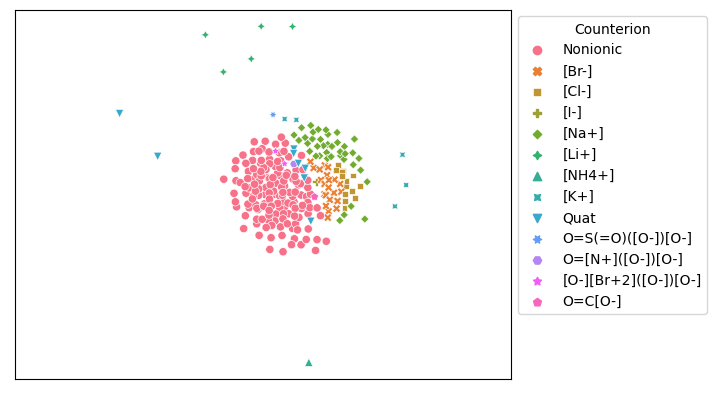

In [23]:
fg = sns.scatterplot(
    kernel_df,
    x="Force X",
    y="Force Y",
    style="Counterion",
    # size="Source",
    hue="Counterion",
    # size_order=["NIST", "Qin"],
    # sizes=(50, 100),
    hue_order=counterion_order,
    style_order=counterion_order,
)
fg.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
plt.axis("equal")
ax = plt.gca()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


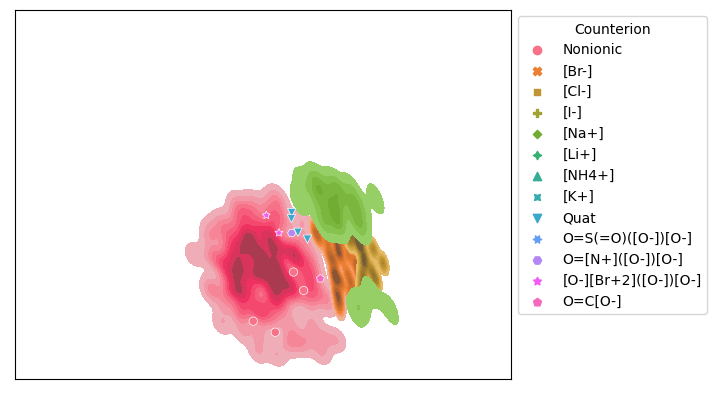

In [13]:
fig, ax = plt.subplots(1, 1)
just_qin = kernel_df[kernel_df["Source"] == "Qin"]

qin_counterion_counts = just_qin["Counterion"].value_counts()
include_kde = just_qin["Counterion"].apply(lambda x: qin_counterion_counts[x] > 2)

included_counterions = set(just_qin[include_kde]["Counterion"].unique())
included_counterions = included_counterions | set(kernel_df[kernel_df["Above 95% CI"]]["Counterion"].unique())
included_counterions = list(included_counterions)

fg = sns.kdeplot(
    just_qin[include_kde],
    x="Force X",
    y="Force Y",
    hue="Counterion",
    hue_order=counterion_order,
    ax=ax,
    fill=True,
    bw_adjust=0.5,
)
sns.scatterplot(
    kernel_df[kernel_df["Above 95% CI"]],
    x="Force X",
    y="Force Y",
    style="Counterion",
    hue="Counterion",
    hue_order=counterion_order,
    style_order=counterion_order,
    ax=ax,
)

fg.set(xlabel=None, ylabel=None, xticks=[], yticks=[])
plt.axis("equal")
ax = plt.gca()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [14]:
fig = px.scatter(kernel_df, x="Force X", y="Force Y", color="Counterion")
fig.update_layout(width=1000, height=1000)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig["layout"].update(scene=dict(aspectmode="data"))
if USE_MOLPLOTLY:
    app = molplotly.add_molecules(fig=fig, df=kernel_df, smiles_col="SMILES", color_col="Counterion")
    app.run_server(mode="inline", port=8700)
else:
    py.iplot(fig, filename='fdg-plot-plotly')

In [15]:
kernel_df[kernel_df["Counterion"] == "Quat"]["SMILES_x"].values

array(['CCCCCCCCC(CC)OS(=O)(=O)[O-].C[N+](C)(C)C',
       'CCCCCCCCC(CC)OS(=O)(=O)[O-].CCC[N+](CCC)(CCC)CCC',
       'CCCCCCCCCCS(=O)(=O)[O-].CCCCCCCCCC[N+](C)(C)C',
       'CCCCCCCCCCOS(=O)(=O)[O-].CCCCCCCCCC[N+](C)(C)C',
       'CCCCCCCC[N+](C)(C)C.CCCCCCCCCCOS(=O)(=O)[O-]',
       'CCCCCCCCCCCCOS(=O)(=O)[O-].CCCCCCCC[N+](C)(C)C',
       'CCCCCCCCS(=O)(=O)[O-].CCCCCCCC[N+](C)(C)C',
       'CCCCCCCCCCCCOS(=O)(=O)[O-].C[N+](C)(C)C'], dtype=object)